# One-shot learning with ResNet & triplet loss

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Training

In [2]:
# Set manual seeds
torch.manual_seed(42)


In [3]:
# Resnet params
FINETUNING = True

# Number of dimensions of the image embedding
OUTPUT_LAYER_SIZE = 128

OPTIM = 'Adam' # 'SGD'
LR = 0.001
MOMENTUM = 0.9

MINIBATCH_SIZE = 16
EPOCHS = 2

# One-shot learning hyperparameter
N_TRIPLETS = 4096
MARGIN = 1

In [4]:
from pokemon_loader import PokemonLoader

In [5]:
import torch.nn as nn
import torch.optim as optim

In [6]:
# Colorwise means and std of ImageNet, used to train resnet
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Transforms to apply
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# The dataset should be in ./kaggle-one-shot-pokemon
# It can be downloaded from 
# https://www.kaggle.com/thedagger/pokemon-generation-one
image_directory = "./kaggle-one-shot-pokemon/"

train_loader = torch.utils.data.DataLoader(
    PokemonLoader(train=True, root_dir=image_directory, preload=True,
                  transform=data_transforms, n=N_TRIPLETS),
                  batch_size=MINIBATCH_SIZE, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    PokemonLoader(train=False, root_dir=image_directory,
                  transform=data_transforms, n=1024),
                  batch_size=MINIBATCH_SIZE, shuffle=True)

100%|██████████| 1024/1024 [00:00<00:00, 76461.00it/s]

Generating 4096 triplets
Generating 1024 matches


In [7]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = models.resnet18(pretrained=True)
net.fc = nn.Linear(in_features=net.fc.in_features, out_features=OUTPUT_LAYER_SIZE, bias=True)
net.to(device)


RuntimeError: CUDA error: out of memory

In [16]:
# Train the given model
def train_model(model, train_loader, optimizer, margin=1, n_epochs=5, val_loader=None):
    ths = []
    accs = []
    for epoch in range(n_epochs):
        model.train(True)
        print(f"======= EPOCH {epoch+1} =======")
        running_loss = 0
        for idx, (img_a, img_p, img_n) in enumerate(train_loader):
            data_a, data_p, data_n = img_a.to(device), img_p.to(device), img_n.to(device)

            out_a, out_p, out_n = model(data_a), model(data_p), model(data_n)
        
            loss = F.triplet_margin_loss(out_a, out_p, out_n, margin=margin)

            running_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if idx % 10 == 9:    # print every 10 mini-batches
                print(f"Batches {idx-8}-{idx+1} loss: {running_loss/10:.5f}")
                running_loss = 0.0
        if val_loader != None:
            model.train(False)
            distances, labels = test_model(val_loader, model)
            th = val_threshold(distances, labels)
            acc = test(distances, labels, th)
            ths.append(th)
            accs.append(acc)
            
    return ths, accs

In [17]:
def test_model(test_loader, model):
    model.train(False)
    
    distances, labels = [], []
    for idx, (img_1, img_2, same) in enumerate(test_loader):
        data_1, data_2 = img_1.to(device), img_2.to(device)
    
        out_1, out_2 = model(data_1), model(data_2)

        dists = torch.sqrt(torch.sum((out_1 - out_2) ** 2, 1))
        distances.extend(dists.data.to('cpu').numpy())
        
        labels.extend(same.data.to('cpu').numpy())

    return distances, labels

def val_threshold(distances, labels):
    are_same = [elt[0] == 1 for elt in labels]

    th = min(distances)

    max_acc, best_th = 0, th

    while th < max(distances):
        acc = test(distances, labels, th)
        if acc > max_acc:
            max_acc, best_th = acc, th
        th += min(0.1, (max(distances) - min(distances)) / 100)

    print(f"Best th: {best_th}, Accuracy: {max_acc:.1f}%")
    
    return best_th

def test(distances, labels, th):
    are_same = [elt[0] == 1 for elt in labels]

    think_same = [elt < th for elt in distances]

    n_TP = 0
    n_TN = 0
    n_FP = 0
    n_FN = 0
    n_total = len(think_same)
    for i in range(n_total):
        if think_same[i] == are_same[i] and think_same[i]:
            n_TP += 1
        if think_same[i] == are_same[i] and (not think_same[i]):
            n_TN += 1
        if think_same[i] != are_same[i] and think_same[i]:
            n_FP += 1
        if think_same[i] != are_same[i] and (not think_same[i]):
            n_FN += 1
    print(f"TP: {n_TP}, TN: {n_TN}, FP: {n_FP}, FN: {n_FN}")
    print(f"Th: {th}, Accuracy: {(100 * (n_TP + n_TN)/n_total):.1f}%")
    print(f"          Precision: {(100 if n_TP == 0 else 100 * n_TP / (n_TP + n_FP)):.1f}%")
    print(f"          Recall: {(0 if n_TP == 0 else 100 * n_TP / (n_TP + n_FN)):.1f}%")
    return 100 * (n_TP + n_TN)/n_total

In [9]:
# Define optimizer
params = net.parameters()

if OPTIM == 'Adam':
    optimizer = optim.Adam(params, lr=LR)
else:
    optimizer = optim.SGD(params, lr=LR, momentum=MOMENTUM)

In [13]:
# Train the model
# Provide a val_loader to calculate validation loss after each epoch
train_model(net, train_loader, optimizer, margin=MARGIN, n_epochs=EPOCHS, val_loader=val_loader)

======= EPOCH 1 =======
Batches 1-10 loss: 0.08187
Batches 11-20 loss: 0.06770
Batches 21-30 loss: 0.02814
Batches 31-40 loss: 0.07014
Batches 41-50 loss: 0.02470
Batches 51-60 loss: 0.07779
Batches 61-70 loss: 0.03881
Batches 71-80 loss: 0.05177
Batches 81-90 loss: 0.16453
Batches 91-100 loss: 0.01059
Batches 101-110 loss: 0.14167
Batches 111-120 loss: 0.04803
Batches 121-130 loss: 0.07345
Batches 131-140 loss: 0.00904
Batches 141-150 loss: 0.04771
Batches 151-160 loss: 0.02266
Batches 161-170 loss: 0.04205
Batches 171-180 loss: 0.04338
Batches 181-190 loss: 0.04096
Batches 191-200 loss: 0.01960
Batches 201-210 loss: 0.00964
Batches 211-220 loss: 0.06017
Batches 221-230 loss: 0.02983
Batches 231-240 loss: 0.01687
Batches 241-250 loss: 0.00000
TP: 0, TN: 512, FP: 0, FN: 512
Th: 1.1808234453201294, Accuracy: 50.0%
          Precision: 100.0%
          Recall: 0.0%
TP: 3, TN: 512, FP: 0, FN: 509
Th: 1.2808234453201295, Accuracy: 50.3%
          Precision: 100.0%
          Recall: 0.6%
TP

TP: 479, TN: 352, FP: 160, FN: 33
Th: 7.680823445320119, Accuracy: 81.2%
          Precision: 75.0%
          Recall: 93.6%
TP: 479, TN: 350, FP: 162, FN: 33
Th: 7.780823445320118, Accuracy: 81.0%
          Precision: 74.7%
          Recall: 93.6%
TP: 485, TN: 341, FP: 171, FN: 27
Th: 7.880823445320118, Accuracy: 80.7%
          Precision: 73.9%
          Recall: 94.7%
TP: 485, TN: 339, FP: 173, FN: 27
Th: 7.980823445320118, Accuracy: 80.5%
          Precision: 73.7%
          Recall: 94.7%
TP: 485, TN: 334, FP: 178, FN: 27
Th: 8.080823445320117, Accuracy: 80.0%
          Precision: 73.2%
          Recall: 94.7%
TP: 485, TN: 328, FP: 184, FN: 27
Th: 8.180823445320117, Accuracy: 79.4%
          Precision: 72.5%
          Recall: 94.7%
TP: 485, TN: 322, FP: 190, FN: 27
Th: 8.280823445320117, Accuracy: 78.8%
          Precision: 71.9%
          Recall: 94.7%
TP: 485, TN: 316, FP: 196, FN: 27
Th: 8.380823445320116, Accuracy: 78.2%
          Precision: 71.2%
          Recall: 94.7%
TP: 490,

          Precision: 52.2%
          Recall: 100.0%
TP: 512, TN: 43, FP: 469, FN: 0
Th: 15.58082344532009, Accuracy: 54.2%
          Precision: 52.2%
          Recall: 100.0%
TP: 512, TN: 40, FP: 472, FN: 0
Th: 15.68082344532009, Accuracy: 53.9%
          Precision: 52.0%
          Recall: 100.0%
TP: 512, TN: 35, FP: 477, FN: 0
Th: 15.78082344532009, Accuracy: 53.4%
          Precision: 51.8%
          Recall: 100.0%
TP: 512, TN: 33, FP: 479, FN: 0
Th: 15.88082344532009, Accuracy: 53.2%
          Precision: 51.7%
          Recall: 100.0%
TP: 512, TN: 31, FP: 481, FN: 0
Th: 15.98082344532009, Accuracy: 53.0%
          Precision: 51.6%
          Recall: 100.0%
TP: 512, TN: 29, FP: 483, FN: 0
Th: 16.08082344532009, Accuracy: 52.8%
          Precision: 51.5%
          Recall: 100.0%
TP: 512, TN: 27, FP: 485, FN: 0
Th: 16.18082344532009, Accuracy: 52.6%
          Precision: 51.4%
          Recall: 100.0%
TP: 512, TN: 26, FP: 486, FN: 0
Th: 16.28082344532009, Accuracy: 52.5%
          Precis

TP: 355, TN: 474, FP: 38, FN: 157
Th: 4.656513595581055, Accuracy: 81.0%
          Precision: 90.3%
          Recall: 69.3%
TP: 359, TN: 468, FP: 44, FN: 153
Th: 4.756513595581055, Accuracy: 80.8%
          Precision: 89.1%
          Recall: 70.1%
TP: 365, TN: 464, FP: 48, FN: 147
Th: 4.856513595581054, Accuracy: 81.0%
          Precision: 88.4%
          Recall: 71.3%
TP: 365, TN: 461, FP: 51, FN: 147
Th: 4.956513595581054, Accuracy: 80.7%
          Precision: 87.7%
          Recall: 71.3%
TP: 368, TN: 460, FP: 52, FN: 144
Th: 5.056513595581054, Accuracy: 80.9%
          Precision: 87.6%
          Recall: 71.9%
TP: 368, TN: 458, FP: 54, FN: 144
Th: 5.156513595581053, Accuracy: 80.7%
          Precision: 87.2%
          Recall: 71.9%
TP: 373, TN: 453, FP: 59, FN: 139
Th: 5.256513595581053, Accuracy: 80.7%
          Precision: 86.3%
          Recall: 72.9%
TP: 373, TN: 450, FP: 62, FN: 139
Th: 5.3565135955810526, Accuracy: 80.4%
          Precision: 85.7%
          Recall: 72.9%
TP: 378

TP: 512, TN: 177, FP: 335, FN: 0
Th: 12.156513595581028, Accuracy: 67.3%
          Precision: 60.4%
          Recall: 100.0%
TP: 512, TN: 174, FP: 338, FN: 0
Th: 12.256513595581028, Accuracy: 67.0%
          Precision: 60.2%
          Recall: 100.0%
TP: 512, TN: 168, FP: 344, FN: 0
Th: 12.356513595581028, Accuracy: 66.4%
          Precision: 59.8%
          Recall: 100.0%
TP: 512, TN: 166, FP: 346, FN: 0
Th: 12.456513595581027, Accuracy: 66.2%
          Precision: 59.7%
          Recall: 100.0%
TP: 512, TN: 164, FP: 348, FN: 0
Th: 12.556513595581027, Accuracy: 66.0%
          Precision: 59.5%
          Recall: 100.0%
TP: 512, TN: 162, FP: 350, FN: 0
Th: 12.656513595581027, Accuracy: 65.8%
          Precision: 59.4%
          Recall: 100.0%
TP: 512, TN: 160, FP: 352, FN: 0
Th: 12.756513595581026, Accuracy: 65.6%
          Precision: 59.3%
          Recall: 100.0%
TP: 512, TN: 157, FP: 355, FN: 0
Th: 12.856513595581026, Accuracy: 65.3%
          Precision: 59.1%
          Recall: 100.0%


TP: 512, TN: 14, FP: 498, FN: 0
Th: 19.656513595581067, Accuracy: 51.4%
          Precision: 50.7%
          Recall: 100.0%
TP: 512, TN: 14, FP: 498, FN: 0
Th: 19.75651359558107, Accuracy: 51.4%
          Precision: 50.7%
          Recall: 100.0%
TP: 512, TN: 14, FP: 498, FN: 0
Th: 19.85651359558107, Accuracy: 51.4%
          Precision: 50.7%
          Recall: 100.0%
TP: 512, TN: 14, FP: 498, FN: 0
Th: 19.95651359558107, Accuracy: 51.4%
          Precision: 50.7%
          Recall: 100.0%
TP: 512, TN: 13, FP: 499, FN: 0
Th: 20.056513595581073, Accuracy: 51.3%
          Precision: 50.6%
          Recall: 100.0%
TP: 512, TN: 13, FP: 499, FN: 0
Th: 20.156513595581075, Accuracy: 51.3%
          Precision: 50.6%
          Recall: 100.0%
TP: 512, TN: 13, FP: 499, FN: 0
Th: 20.256513595581076, Accuracy: 51.3%
          Precision: 50.6%
          Recall: 100.0%
TP: 512, TN: 13, FP: 499, FN: 0
Th: 20.356513595581077, Accuracy: 51.3%
          Precision: 50.6%
          Recall: 100.0%
TP: 512, TN

TP: 512, TN: 1, FP: 511, FN: 0
Th: 27.256513595581175, Accuracy: 50.1%
          Precision: 50.0%
          Recall: 100.0%
TP: 512, TN: 1, FP: 511, FN: 0
Th: 27.356513595581177, Accuracy: 50.1%
          Precision: 50.0%
          Recall: 100.0%
TP: 512, TN: 1, FP: 511, FN: 0
Th: 27.45651359558118, Accuracy: 50.1%
          Precision: 50.0%
          Recall: 100.0%
TP: 512, TN: 1, FP: 511, FN: 0
Th: 27.55651359558118, Accuracy: 50.1%
          Precision: 50.0%
          Recall: 100.0%
TP: 512, TN: 1, FP: 511, FN: 0
Th: 27.65651359558118, Accuracy: 50.1%
          Precision: 50.0%
          Recall: 100.0%
TP: 512, TN: 1, FP: 511, FN: 0
Th: 27.756513595581183, Accuracy: 50.1%
          Precision: 50.0%
          Recall: 100.0%
TP: 512, TN: 1, FP: 511, FN: 0
Th: 27.856513595581184, Accuracy: 50.1%
          Precision: 50.0%
          Recall: 100.0%
TP: 512, TN: 1, FP: 511, FN: 0
Th: 27.956513595581185, Accuracy: 50.1%
          Precision: 50.0%
          Recall: 100.0%
TP: 512, TN: 1, FP:

([6.180823445320124, 5.6565135955810515], [85.7421875, 82.71484375])

## Testing

In [10]:
# Test parameters

# Resnet params
T_FINETUNING = True

# Number of dimensions of the image embedding
T_OUTPUT_LAYER_SIZE = 128

T_OPTIM = 'SGD' # Adam
T_LR = 0.001
T_MOMENTUM = 0.9

T_MINIBATCH_SIZE = 16
T_EPOCHS = 4

# One-shot learning hyperparameters
T_N_TRIPLETS = 4096
T_MARGIN = 1
T_THRESHOLD = 6.00

In [12]:
net = models.resnet18(pretrained=True)

net.fc = nn.Linear(in_features=net.fc.in_features, out_features=T_OUTPUT_LAYER_SIZE, bias=True)
net.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [21]:
train_loader = torch.utils.data.DataLoader(
    PokemonLoader(train=True, root_dir=image_directory, preload=True,
                  transform=data_transforms, n=T_N_TRIPLETS),
                  batch_size=MINIBATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    PokemonLoader(train=False, matches=True, root_dir=image_directory,
                  transform=data_transforms, n=1024),
                  batch_size=MINIBATCH_SIZE, shuffle=True)

test_loader_hard = torch.utils.data.DataLoader(
    PokemonLoader(train=False, matches=True, hard=True, root_dir=image_directory,
                  transform=data_transforms, n=1024),
                  batch_size=MINIBATCH_SIZE, shuffle=True)

100%|██████████| 1024/1024 [00:00<00:00, 136041.53it/s]

Generating 4096 triplets
Generating 1024 matches
Generating 1024 matches


In [14]:
# Define optimizer
params = net.parameters()

if T_OPTIM == 'Adam':
    optimizer = optim.Adam(params, lr=T_LR)
else:
    optimizer = optim.SGD(params, lr=T_LR, momentum=T_MOMENTUM)

In [19]:
train_model(net, train_loader, optimizer, margin=T_MARGIN, n_epochs=T_EPOCHS)

======= EPOCH 1 =======
Batches 1-10 loss: 0.26686
Batches 11-20 loss: 0.09264
Batches 21-30 loss: 0.03753
Batches 31-40 loss: 0.03163
Batches 41-50 loss: 0.02508
Batches 51-60 loss: 0.01018
Batches 61-70 loss: 0.02313
Batches 71-80 loss: 0.01398
Batches 81-90 loss: 0.00065
Batches 91-100 loss: 0.00672
Batches 101-110 loss: 0.00111
Batches 111-120 loss: 0.01678
Batches 121-130 loss: 0.00292
Batches 131-140 loss: 0.00191
Batches 141-150 loss: 0.00739
Batches 151-160 loss: 0.00875
Batches 161-170 loss: 0.00233
Batches 171-180 loss: 0.00531
Batches 181-190 loss: 0.00367
Batches 191-200 loss: 0.00382
Batches 201-210 loss: 0.00613
Batches 211-220 loss: 0.00310
Batches 221-230 loss: 0.00000
Batches 231-240 loss: 0.00201
Batches 241-250 loss: 0.00681
======= EPOCH 2 =======
Batches 1-10 loss: 0.00000
Batches 11-20 loss: 0.00000
Batches 21-30 loss: 0.00050
Batches 31-40 loss: 0.00000
Batches 41-50 loss: 0.00711
Batches 51-60 loss: 0.00192
Batches 61-70 loss: 0.00000
Batches 71-80 loss: 0.00000

([], [])

In [22]:
distances, labels = test_model(test_loader, net)
test(distances, labels, T_THRESHOLD)
distances, labels = test_model(test_loader_hard, net)
test(distances, labels, T_THRESHOLD)

TP: 445, TN: 489, FP: 23, FN: 67
Th: 6.0, Accuracy: 91.2%
          Precision: 95.1%
          Recall: 86.9%
TP: 92, TN: 505, FP: 7, FN: 420
Th: 6.0, Accuracy: 58.3%
          Precision: 92.9%
          Recall: 18.0%


58.30078125

torch.Size([16, 3, 224, 224])


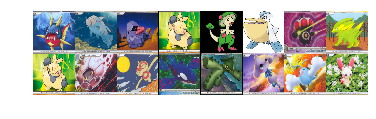

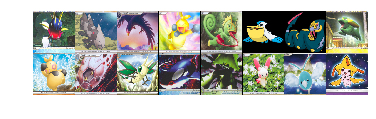

[True, True, False, True, False, True, False, False, True, True, False, True, False, False, True, False]
[True, True, False, True, False, True, False, True, True, True, False, True, True, False, True, False]
[False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False]


In [25]:
def imshow(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

def denormalize(img):
    denorm = transforms.Compose([
        transforms.Normalize(mean=-mean/std, std=1/std),
    ])
    t_list = [denorm(m) for m in torch.unbind(img, dim=0)]
    res = torch.stack(t_list, dim=0)
    return res

idx, (img_1, img_2, same) = next(enumerate(test_loader_hard))
data_1, data_2 = img_1.to(device), img_2.to(device)



imshow(torchvision.utils.make_grid(denormalize(img_1)))
imshow(torchvision.utils.make_grid(denormalize(img_2)))



out_1, out_2 = net(data_1), net(data_2)

dists = torch.sqrt(torch.sum((out_1 - out_2) ** 2, 1))
distances = dists.data.to('cpu').numpy()
think_same = [elt < th for elt in distances]
print(think_same)
labels = same.data.to('cpu').numpy()
are_same = [elt[0] == 1 for elt in labels]
print(are_same)

different = [are_same[i] != think_same[i] for i in range(len(are_same))]
print(different)

In [31]:
torch.cuda.is_available()

True